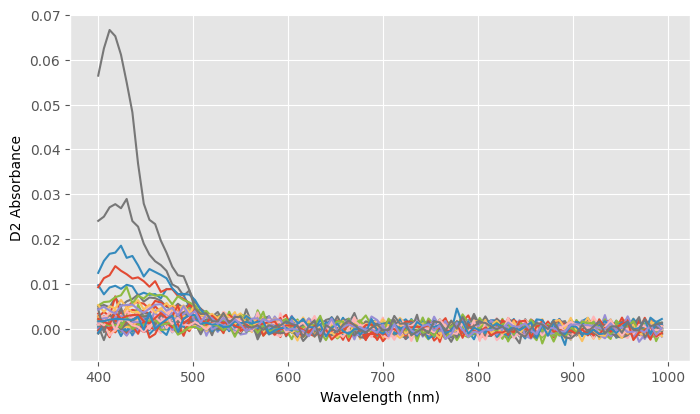

ValueError: Found input variables with inconsistent numbers of samples: [60, 200]

In [13]:
from sys import stdout
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

data = pd.read_csv('./updated_dataset_for_cdom.csv')
y1 = data['cdom']
X1 = data.filter(like='wvl_')
random_state=42
np.random.seed(random_state)
scale_values = [0.1 , 0.01 , 0.001]
indices = np.arange(len(X))
for x in scale_values:
    test_indices = np.random.choice(indices, size=int(0.3 * len(X1)), replace=False)
   
    X =  pd.DataFrame(X1).loc[test_indices] + np.random.normal(loc=0, scale=x, size=(len(test_indices), X1.shape[1]))
    Y =  pd.DataFrame(y1).loc[test_indices]
wl = np.arange(400,1000,6)

X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)
 

plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
   
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
       
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/n_comp
       
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
   
    pls_opt = PLSRegression(n_components=msemin+1)
 
   
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
  
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
 
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
   
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    mae_c=mean_absolute_error(y,y_c)
    mae_cv=mean_absolute_error(y,y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MAE calib: %5.3f' % mae_c)
    print('MAE CV: %5.3f' % mae_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

 
    
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
   
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted cdom')
        plt.ylabel('Measured cdom')
 
        plt.show()
 
    return


optimise_pls_cv(X,y,30, plot_components=True)

